In [1]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

2025-06-18 10:50:35.001512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X_train = joblib.load('../../preprocessed_data/CICIDS/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/CICIDS/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/CICIDS/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/CICIDS/Y_test.joblib')

### CNN training

In [3]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.3), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 67, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 33, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 33, 32)            0         
                                                                 
 flatten (Flatten)           (None, 1056)              0         
                                                                 
 dense (Dense)               (None, 64)                67648     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

2025-06-18 10:50:38.141974: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 546899520 exceeds 10% of free system memory.


30958/30962 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9591

2025-06-18 10:51:44.771590: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 234385548 exceeds 10% of free system memory.


30962/30962 [==============================] - 75s 2ms/step - loss: 0.1015 - accuracy: 0.9591 - val_loss: 0.0722 - val_accuracy: 0.9679
Epoch 2/5
30962/30962 [==============================] - 74s 2ms/step - loss: 0.0832 - accuracy: 0.9653 - val_loss: 0.0667 - val_accuracy: 0.9696
Epoch 3/5
30962/30962 [==============================] - 75s 2ms/step - loss: 0.0795 - accuracy: 0.9665 - val_loss: 0.0667 - val_accuracy: 0.9699
Epoch 4/5
30962/30962 [==============================] - 81s 3ms/step - loss: 0.0774 - accuracy: 0.9672 - val_loss: 0.0657 - val_accuracy: 0.9712
Epoch 5/5
30962/30962 [==============================] - 73s 2ms/step - loss: 0.0768 - accuracy: 0.9678 - val_loss: 0.0639 - val_accuracy: 0.9713


### LSTM training

In [4]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5


2025-06-18 10:56:57.374244: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 546899520 exceeds 10% of free system memory.


30961/30962 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9496

2025-06-18 11:05:59.600223: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 234385548 exceeds 10% of free system memory.


30962/30962 [==============================] - 632s 20ms/step - loss: 0.1251 - accuracy: 0.9496 - val_loss: 0.0808 - val_accuracy: 0.9653
Epoch 2/5
30962/30962 [==============================] - 614s 20ms/step - loss: 0.0765 - accuracy: 0.9673 - val_loss: 0.0669 - val_accuracy: 0.9720
Epoch 3/5
30962/30962 [==============================] - 615s 20ms/step - loss: 0.0684 - accuracy: 0.9708 - val_loss: 0.0642 - val_accuracy: 0.9716
Epoch 4/5
30962/30962 [==============================] - 610s 20ms/step - loss: 0.0644 - accuracy: 0.9724 - val_loss: 0.0619 - val_accuracy: 0.9734
Epoch 5/5
30962/30962 [==============================] - 623s 20ms/step - loss: 0.0621 - accuracy: 0.9732 - val_loss: 0.0608 - val_accuracy: 0.9737


### AE-LSTM

In [5]:
input_dim = X_train.shape[1]  # n_features

# encoder
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test)
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 69, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65    

2025-06-18 11:48:32.755357: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 546899520 exceeds 10% of free system memory.


30962/30962 [==============================] - 620s 20ms/step - loss: 0.1150 - accuracy: 0.9517 - val_loss: 0.0763 - val_accuracy: 0.9691
Epoch 2/5
30962/30962 [==============================] - 625s 20ms/step - loss: 0.0787 - accuracy: 0.9674 - val_loss: 0.0708 - val_accuracy: 0.9708
Epoch 3/5
30962/30962 [==============================] - 645s 21ms/step - loss: 0.0709 - accuracy: 0.9700 - val_loss: 0.0707 - val_accuracy: 0.9703
Epoch 4/5
30962/30962 [==============================] - 636s 21ms/step - loss: 0.0681 - accuracy: 0.9712 - val_loss: 0.0660 - val_accuracy: 0.9718
Epoch 5/5
30962/30962 [==============================] - 626s 20ms/step - loss: 0.0653 - accuracy: 0.9721 - val_loss: 0.0662 - val_accuracy: 0.9716


In [6]:
CNN_model.save("../../models/cnn_CICIDS2017_model.keras")
LSTM_model.save("../../models/lstm_CICIDS2017_model.keras")
AE_LSTM_model.save("../../models/ae-lstm_CICIDS2017_model.keras")

In [7]:
file_name_cnn = '../../models/cnn_CICIDS2017.pkl' 
joblib.dump(CNN_model, file_name_cnn) 

file_name_lstm = '../../models/lstm_CICIDS2017.pkl' 
joblib.dump(LSTM_model, file_name_lstm) 

file_name_ae_lstm = '../../models/ae-lstm_CICIDS2017.pkl' 
joblib.dump(AE_LSTM_model, file_name_ae_lstm)

['../../models/ae-lstm_CICIDS2017.pkl']

### CNN metrics

26539/26539 [==============================] - 31s 1ms/step
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98    681929
     Attacks       0.91      0.94      0.93    167294

    accuracy                           0.97    849223
   macro avg       0.95      0.96      0.96    849223
weighted avg       0.97      0.97      0.97    849223

Test Loss: 0.0639
Test Accuracy: 0.9713


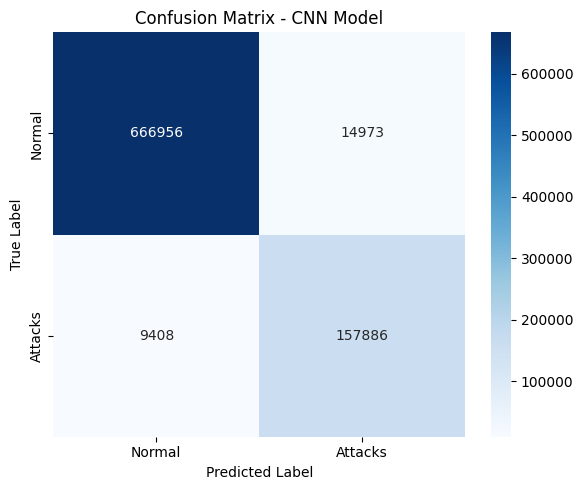

Attacks detected (True Positive) : 157886
Normal traffic detected (True Negative) : 666956
Attacks missed (False Negative) : 9408
False alarms (False Positive) : 14973


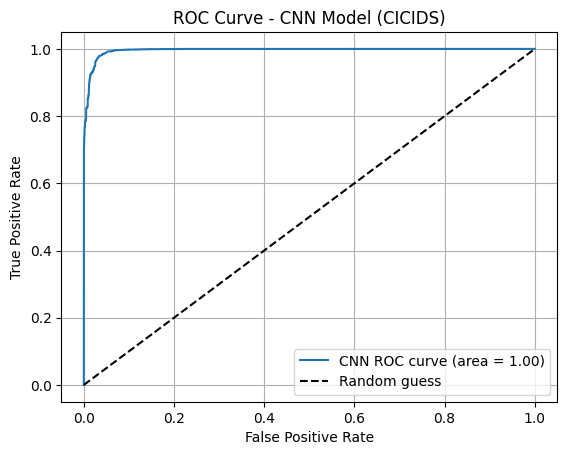

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.savefig("../../results/CICIDS/CNN_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (CICIDS)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIDS/CNN_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### LSTM metrics

26539/26539 [==============================] - 192s 7ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98    681929
     Attacks       0.94      0.92      0.93    167294

    accuracy                           0.97    849223
   macro avg       0.96      0.96      0.96    849223
weighted avg       0.97      0.97      0.97    849223

Test Loss: 0.0608
Test Accuracy: 0.9737


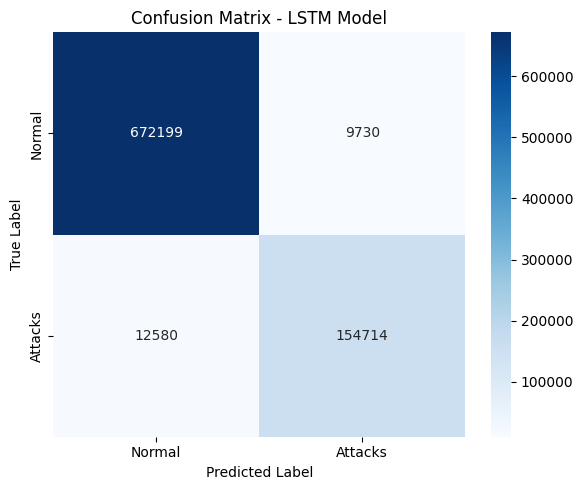

Attacks detected (True Positive) : 154714
Normal traffic detected (True Negative) : 672199
Attacks missed (False Negative) : 12580
False alarms (False Positive) : 9730


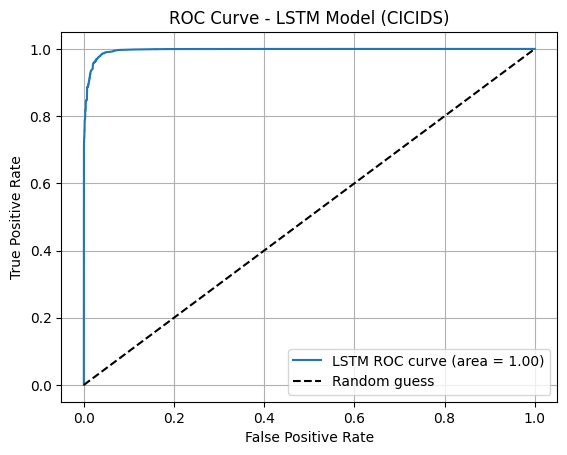

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = LSTM_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIDS/LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (CICIDS)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIDS/LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### AE-LSTM metrics

26539/26539 [==============================] - 186s 7ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98    681929
     Attacks       0.92      0.94      0.93    167294

    accuracy                           0.97    849223
   macro avg       0.95      0.96      0.96    849223
weighted avg       0.97      0.97      0.97    849223

Test Loss: 0.0662
Test Accuracy: 0.9716


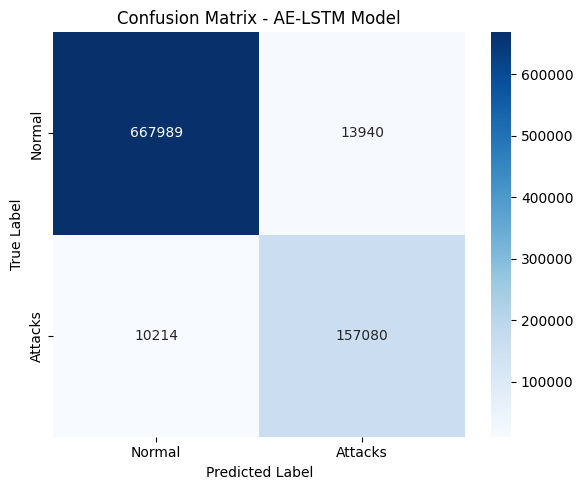

Attacks detected (True Positive) : 157080
Normal traffic detected (True Negative) : 667989
Attacks missed (False Negative) : 10214
False alarms (False Positive) : 13940


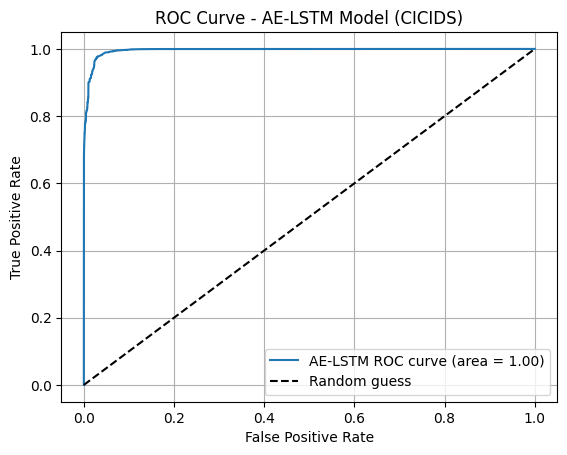

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = AE_LSTM_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIDS/AE-LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (CICIDS)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIDS/AE-LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
